# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 25.09.2022

Мягкий дедлайн: 23:59MSK 10.10.2022

Жесткий дедлайн: 23:59MSK 18.10.2022

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [80]:
!pip install folium


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: C:\Users\MagicBook\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [81]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [83]:
import urllib.request

url = "https://www.kaggle.com/c/nyc-taxi-trip-duration/overview"
filename = "data.csv"

urllib.request.urlretrieve(url, filename)

('data.csv', <http.client.HTTPMessage at 0x2340b751e50>)

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [84]:
import pandas
from datetime import datetime
data = pandas.read_csv('train.csv')

data = data.drop(columns=['dropoff_datetime'])
# Преобразуйте столбец timestamp в datetime-объекты
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

# Проверьте тип данных столбца
print(data['pickup_datetime'].dtype)
print(data.keys())

datetime64[ns]
Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration'],
      dtype='object')


В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

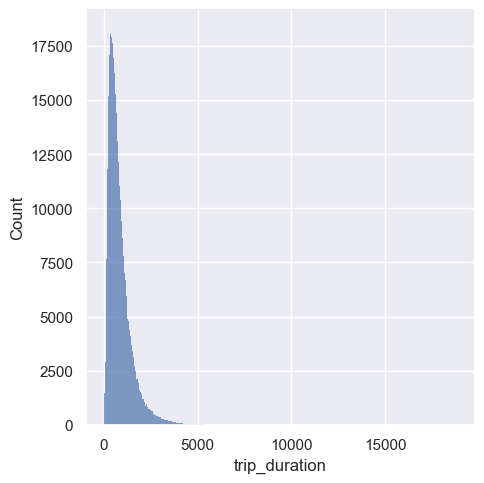

In [85]:
data = data.loc[data['trip_duration']<20000]
sns.displot(x=data['trip_duration'])

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: Мы знаем $$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$ Также мы знаем, что $\hat{y}_i = \log{(y_i + 1)}$ и $a(x_i) = e^{\hat{a}(x_i)} - 1 \Rightarrow a(x_i)-1 = e^{\hat{a}(x_i)} \Rightarrow \log a(x_i)-1 = \hat{a}(x_i)$

Преобразуем выражение $\text{RMSLE}(X, y, a)$ и получим $$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big( \hat{y}_i - \hat{a}(x_i) \big)^2} = \text{RMSE}(X, \hat{y}, \hat{a})$$

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [86]:
# data = data.assign(log_trip_duration=np.log1p(data['trip_duration']))
data.loc[:, 'log_trip_duration'] = np.log1p(data['trip_duration'].values)
# data = data.drop('trip_duration', axis=1)

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

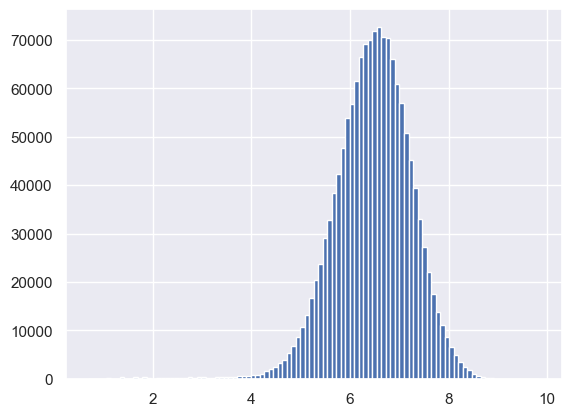

Значение метрики RMSLE для наилучшего константного предсказания: 631.6654591184632


In [87]:
plt.hist(data['log_trip_duration'], bins=100)
plt.show()

best_constant_prediction = np.expm1(data['log_trip_duration'].mean())
rmsle_best_constant = np.sqrt((np.mean(data['log_trip_duration'] - best_constant_prediction)**2))
print(f"Значение метрики RMSLE для наилучшего константного предсказания: {rmsle_best_constant}")

## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

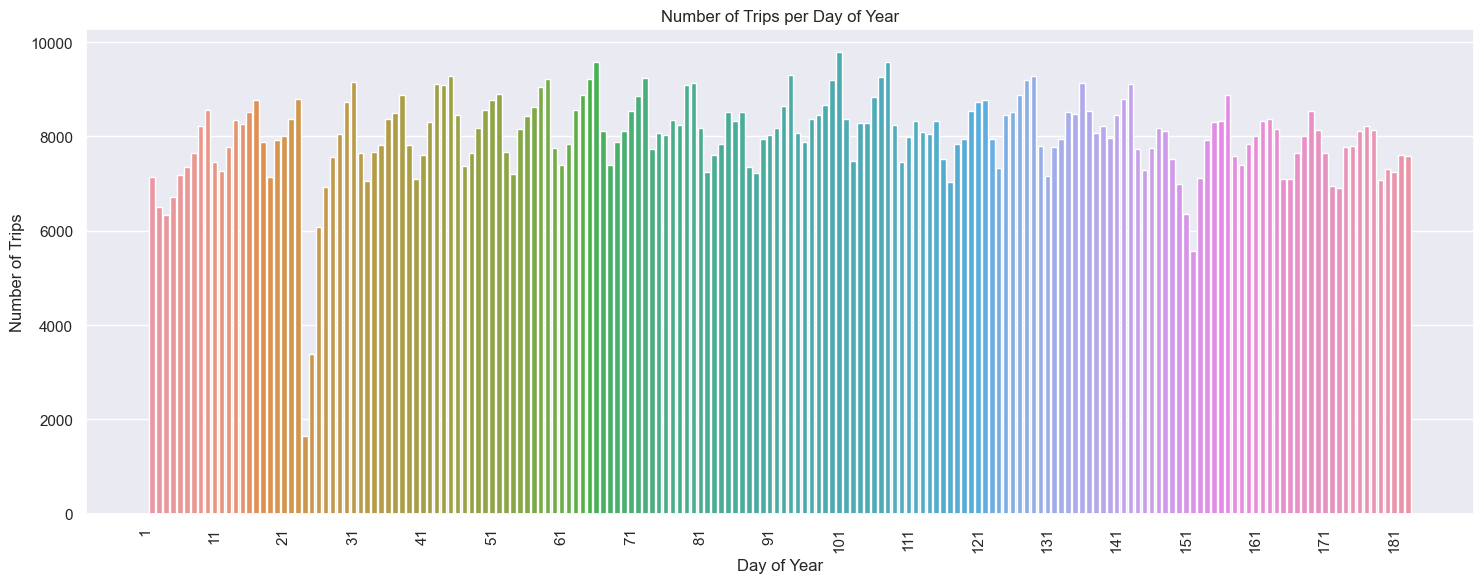

In [88]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['day_of_year'] = data['pickup_datetime'].dt.dayofyear

plt.figure(figsize=(15, 6))
sns.countplot(x='day_of_year', data=data)
plt.xlabel('Day of Year')
plt.ylabel('Number of Trips')
plt.title('Number of Trips per Day of Year')

plt.xticks(rotation=45, ha='right')
plt.locator_params(axis='x', nbins=20)  # Установите желаемое количество подписей

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

Аномальные даты с малым количеством поездок:
23 2016-01-23
24 2016-01-24
25 2016-01-25
151 2016-05-30


<Figure size 1200x600 with 0 Axes>

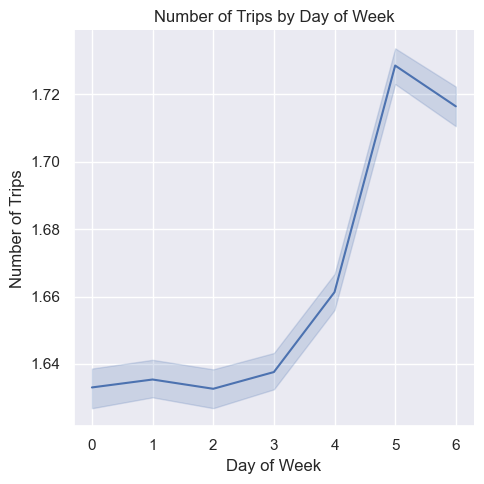

<Figure size 1200x600 with 0 Axes>

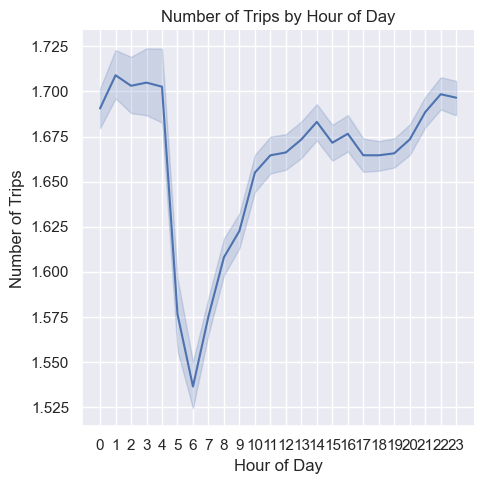

In [89]:
trip_counts = data['day_of_year'].value_counts().sort_index()

mean_trip_count = trip_counts.mean()
std_trip_count = trip_counts.std()

anomalous_dates = trip_counts[trip_counts < (mean_trip_count - 2 * std_trip_count)]

print("Аномальные даты с малым количеством поездок:")
for date in anomalous_dates.index:
    print(date, data[data['day_of_year'] == date]['pickup_datetime'].dt.strftime('%Y-%m-%d').iloc[0])


data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

data['day_of_week'] = data['pickup_datetime'].dt.dayofweek

data['hour_of_day'] = data['pickup_datetime'].dt.hour

plt.figure(figsize=(12, 6))
sns.relplot(x='day_of_week', y='passenger_count', data=data, kind='line')
plt.xlabel('Day of Week')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Day of Week')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.relplot(x='hour_of_day', y='passenger_count', data=data, kind='line')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Hour of Day')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'log_trip_duration', 'day_of_year', 'day_of_week', 'hour_of_day',
       'month'],
      dtype='object')


C:\Users\MagicBook\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)


<Figure size 2000x600 with 0 Axes>

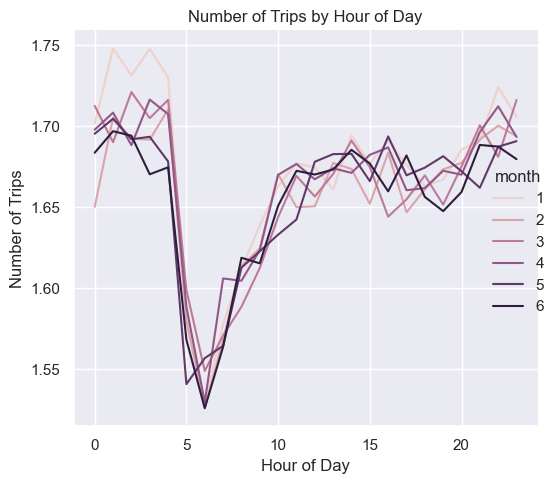

C:\Users\MagicBook\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)


<Figure size 2000x600 with 0 Axes>

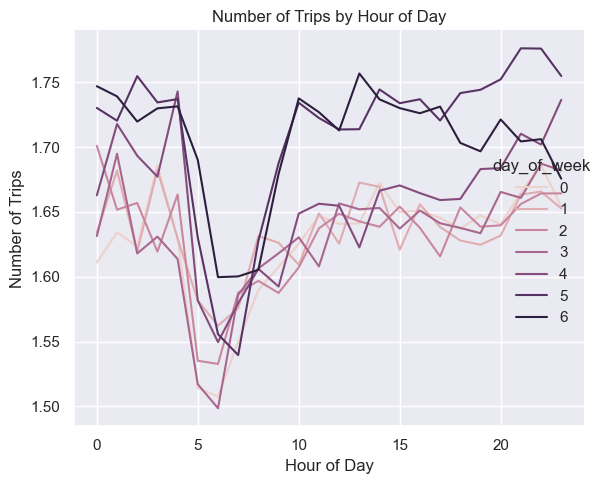

In [90]:
data['month'] = data['pickup_datetime'].dt.month

print(data.keys())

plt.figure(figsize=(20, 6))
sns.relplot(x='hour_of_day', y='passenger_count', hue='month', data=data, kind='line', ci=None)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Hour of Day')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 6))
sns.relplot(x='hour_of_day', y='passenger_count', hue='day_of_week', data=data, kind='line', ci=None)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Hour of Day')
plt.tight_layout()
plt.show()




**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?
**Ответ**: В выходные гораздо дольше ездят. Также интересно, что в январе ночью ездят чаще, чем в любой другой месяц ночью. В остальное время в среднем одинаково по времени.

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'log_trip_duration', 'day_of_year', 'day_of_week', 'hour_of_day',
       'month'],
      dtype='object')


<Figure size 1200x600 with 0 Axes>

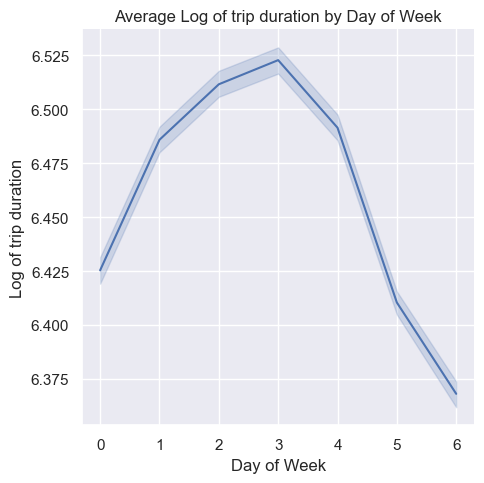

<Figure size 2000x600 with 0 Axes>

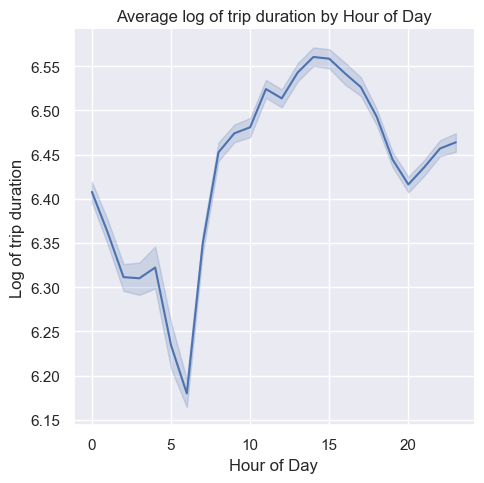

<Figure size 2000x600 with 0 Axes>

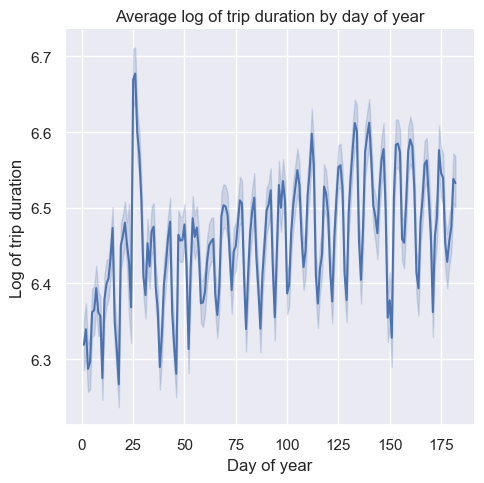

In [91]:
from sklearn.model_selection import train_test_split

print(data.keys())
target = 'log_trip_duration'

X = data
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)


plt.figure(figsize=(12, 6))
sns.relplot(x='day_of_week', y=y_train, data=X_train, kind='line')
plt.xlabel('Day of Week')
plt.ylabel('Log of trip duration')
plt.title('Average Log of trip duration by Day of Week')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 6))
sns.relplot(x='hour_of_day', y=y_train,  data=X_train, kind='line')
plt.xlabel('Hour of Day')
plt.ylabel('Log of trip duration')
plt.title('Average log of trip duration by Hour of Day')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 6))
sns.relplot(x='day_of_year', y=y_train,  data=X_train, kind='line')
plt.xlabel('Day of year')
plt.ylabel('Log of trip duration')
plt.title('Average log of trip duration by day of year')
plt.tight_layout()
plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

**Ответ**: Заметно, что в выходные среднее время поездок меньше, чем в будни. Это заметно на графике с днями года, видно, как периодично функция принимает маленькие значения - это выходные. В те два аномальные периода происходят выбросы в данных, в 23-25 день происходит чрезмерно вы

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [92]:
data['period_anomaly'] = data['day_of_year'].apply(lambda x: 1 if x in [23, 24, 25] else 0)
print(data.keys())
X['period_anomaly'] = X['day_of_year'].apply(lambda x: 1 if x in [23, 24, 25] else 0)
print(X.keys())
print(y.keys())

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'log_trip_duration', 'day_of_year', 'day_of_week', 'hour_of_day',
       'month', 'period_anomaly'],
      dtype='object')
Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'log_trip_duration', 'day_of_year', 'day_of_week', 'hour_of_day',
       'month', 'period_anomaly'],
      dtype='object')
Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            1458634, 1458635, 1458636, 1458637, 1458638, 1458639, 1458640,
            1458641, 1458642, 1458643],
           dtype='int64', length=1456576)


Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?
**Ответ**: Я бы сделал месяц, день недели и то, является ли период аномальным категориальными признаками. Так как за численное представление (с очевидным отношением порядка) отвечает номер дня в году. А аномальность очевидно категориальный признак

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [93]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), ['month', 'day_of_week', 'period_anomaly']),
    ('scaling', StandardScaler(), ['hour_of_day', 'day_of_year'])
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

print(data.keys())

Test RMSE = 0.7703
Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'log_trip_duration', 'day_of_year', 'day_of_week', 'hour_of_day',
       'month', 'period_anomaly'],
      dtype='object')


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [94]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [95]:
show_circles_on_map(data.sample(5000), "pickup_latitude", "pickup_longitude", "blue")

In [96]:
# Порт
# 40.781685, -73.885541
# 40.765592, -73.858869


# Правый нижний аэропорт
# 40.631146, -73.759117
# 40.661726, -73.807449

**Вопрос**: Какие две точки выделяются на карте?

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [97]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h*1000

data.loc[:, 'haversine'] = haversine_array(data['pickup_latitude'].values, data['pickup_longitude'].values, data['dropoff_latitude'].values, data['dropoff_longitude'].values)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [98]:
data.loc[:, 'log_haversine'] = np.log1p(data['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [99]:
corr_log_haversine = data['log_haversine'].corr(data['log_trip_duration'])
corr_haversine = data['haversine'].corr(data['log_trip_duration'])

print('Корреляция log_haversine и log_trip_duration:', corr_log_haversine)
print('Корреляция haversine и log_trip_duration:', corr_haversine)


Корреляция log_haversine и log_trip_duration: 0.7418829305157437
Корреляция haversine и log_trip_duration: 0.5885832170025258


**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

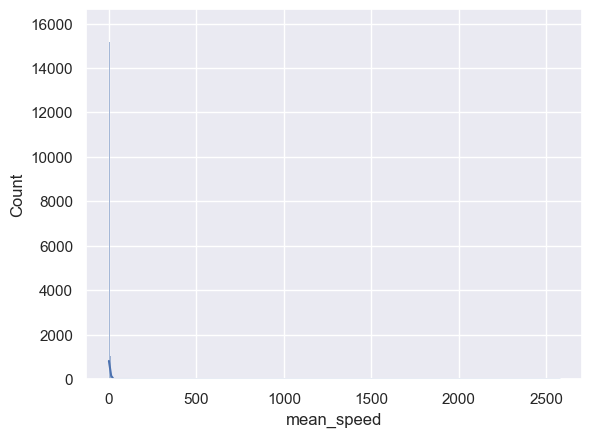

In [100]:
import seaborn as sns

data.loc[:, 'mean_speed'] = data['haversine'].values / data['trip_duration'].values

sns.histplot(data['mean_speed'], kde=True)
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

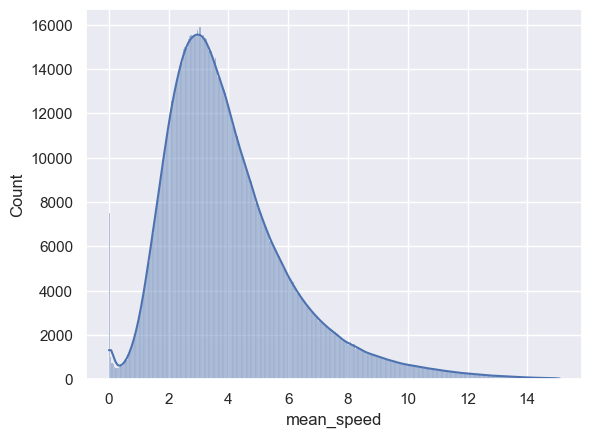

In [101]:
filtered_data = data[data['mean_speed'] <= data['mean_speed'].quantile(0.999)]

sns.histplot(filtered_data['mean_speed'], kde=True)
plt.show()


Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

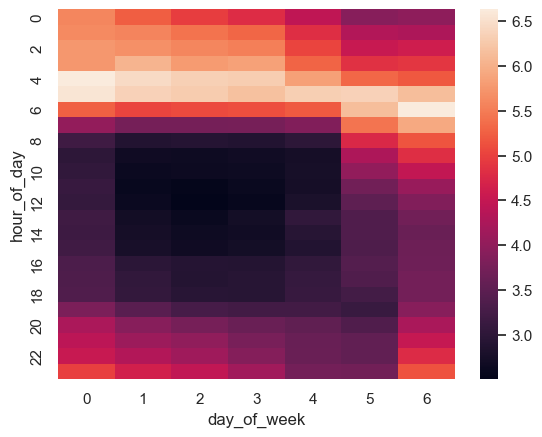

In [102]:
import seaborn as sns

median_speed = data.groupby(['hour_of_day', 'day_of_week'])['mean_speed'].median().unstack()
sns.heatmap(data=median_speed)
plt.show()


Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

In [103]:
data = data.drop(columns=['mean_speed'])
print(data.keys())

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'log_trip_duration', 'day_of_year', 'day_of_week', 'hour_of_day',
       'month', 'period_anomaly', 'haversine', 'log_haversine'],
      dtype='object')


**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.
**Ответ**: Минимальна в период с 8 утра и до 6 вечера. Максимальна ночью

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [104]:
# Функция, которая определяет, является ли время начала поездки периодом пробок
def is_traffic_peak(time):
    hour = time.hour
    if 8 <= hour <= 21:
        return 1
    return 0

data.loc[:, 'traffic_peak'] = data['pickup_datetime'].agg(is_traffic_peak)
data.loc[:, 'free_roads'] = 1 - data['traffic_peak'].values

print(data.keys())

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'log_trip_duration', 'day_of_year', 'day_of_week', 'hour_of_day',
       'month', 'period_anomaly', 'haversine', 'log_haversine', 'traffic_peak',
       'free_roads'],
      dtype='object')


**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [105]:
# Порт
# 40.781685, -73.885541
# 40.765592, -73.858869


# Правый нижний аэропорт
# 40.631146, -73.759117
# 40.661726, -73.807449

latitude_limits1 = [40.637044, 40.855256]
longitude_limits1 = [-74.035735, -73.770272]

class Limits:
    def __init__(self, lat1, lat2, lon1, lon2):
        self.lat1 = min(lat1, lat2)
        self.lat2 = max(lat1, lat2)
        self.lon1 = min(lon1, lon2)
        self.lon2 = max(lon1, lon2)

    def in_bounds(self, lat, lon):
        return self.lat1 <= lat <= self.lat2 and self.lon1 <= lon <= self.lon2

limits1 = Limits(40.765592, 40.781685, -73.858869, -73.885541)
limits2 = Limits(40.631146, 40.661726, -73.759117, -73.807449)

def is_in_location(lat, lon, limits: Limits):
    return limits.in_bounds(lat, lon)

data.loc[:, 'start_in_location_1'] = data.apply(lambda row: is_in_location(row['pickup_latitude'], row['pickup_longitude'], limits1), axis=1)
data.loc[:, 'end_in_location_1'] = data.apply(lambda row: is_in_location(row['dropoff_latitude'], row['dropoff_longitude'], limits1), axis=1)
data.loc[:, 'start_in_location_2'] = data.apply(lambda row: is_in_location(row['pickup_latitude'], row['pickup_longitude'], limits2), axis=1)
data.loc[:, 'end_in_location_2'] = data.apply(lambda row: is_in_location(row['dropoff_latitude'], row['dropoff_longitude'], limits2), axis=1)

data.head()

id  vendor_id     pickup_datetime  passenger_count  \
0  id2875421          2 2016-03-14 17:24:55                1   
1  id2377394          1 2016-06-12 00:43:35                1   
2  id3858529          2 2016-01-19 11:35:24                1   
3  id3504673          2 2016-04-06 19:32:31                1   
4  id2181028          2 2016-03-26 13:30:55                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         40.765602   
1        -73.980415        40.738564         -73.999481         40.731152   
2        -73.979027        40.763939         -74.005333         40.710087   
3        -74.010040        40.719971         -74.012268         40.706718   
4        -73.973053        40.793209         -73.972923         40.782520   

  store_and_fwd_flag  trip_duration  ...  month  period_anomaly    haversine  \
0                  N            455  ...      3               0  1498.520780   
1                  N            663  ...      6               0  1805.507169   
2                  N           2124  ...      1               0  6385.098495   
3                  N            429  ...      4               0  1485.498423   
4                  N            435  ...      3               0  1188.588459   

   log_haversine  traffic_peak  free_roads  start_in_location_1  \
0       7.312901             1           0                False   
1       7.499151             0           1                False   
2       8.761879             1           0                False   
3       7.304179             1           0                False   
4       7.081363             1           0                False   

   end_in_location_1  start_in_location_2  end_in_location_2  
0              False                False              False  
1              False                False              False  
2              False                False              False  
3              False                False              False  
4              False                False              False  

[5 rows x 24 columns]

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

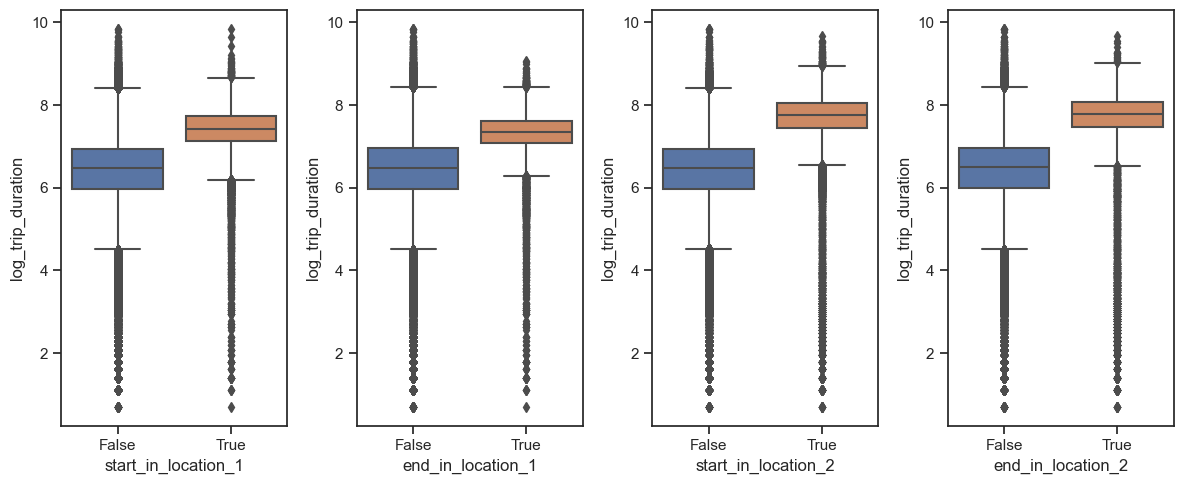

In [106]:
sns.set(style="ticks")

fig, axes = plt.subplots(1, 4, figsize=(12, 5))
sns.boxplot(data=data, x='start_in_location_1', y=data['log_trip_duration'], ax=axes[0])
sns.boxplot(data=data, x='end_in_location_1', y=data['log_trip_duration'], ax=axes[1])
sns.boxplot(data=data, x='start_in_location_2', y=data['log_trip_duration'], ax=axes[2])
sns.boxplot(data=data, x='end_in_location_2', y=data['log_trip_duration'], ax=axes[3])
plt.tight_layout()
plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [107]:
from sklearn.base import BaseEstimator, TransformerMixin

# 40.897935, -74.05655
# 40.620376, -73.744065


class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, rows, columns):
        self.rows = rows
        self.columns = columns
        self.global_limits = Limits(40.620376, 40.897935, -74.05655, -73.744065)
        self.lat_len = self.global_limits.lat2 - self.global_limits.lat1
        self.lon_len = self.global_limits.lon2 - self.global_limits.lon1

    def get_cell_number(self, lat, lon):
        if not self.global_limits.in_bounds(lat, lon):
            return -1
        full_rows_count = int((lon-self.global_limits.lon1)/(self.lon_len / self.rows))
        result = full_rows_count*self.columns + int((lat-self.global_limits.lat1)/(self.lat_len/self.columns))
        return result

    def transform(self, data):
        d1 = data.copy()
        d1['start_cell'] = d1.apply(lambda x: self.get_cell_number(x['pickup_latitude'], x['pickup_longitude']), axis=1)
        d1['end_cell'] = d1.apply(lambda x: self.get_cell_number(x['dropoff_latitude'], x['dropoff_longitude']), axis=1)
        return d1

data.keys()

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'log_trip_duration', 'day_of_year', 'day_of_week', 'hour_of_day',
       'month', 'period_anomaly', 'haversine', 'log_haversine', 'traffic_peak',
       'free_roads', 'start_in_location_1', 'end_in_location_1',
       'start_in_location_2', 'end_in_location_2'],
      dtype='object')

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [108]:
transformer = MapGridTransformer(10, 10)
train = transformer.transform(data)
train.head()

id  vendor_id     pickup_datetime  passenger_count  \
0  id2875421          2 2016-03-14 17:24:55                1   
1  id2377394          1 2016-06-12 00:43:35                1   
2  id3858529          2 2016-01-19 11:35:24                1   
3  id3504673          2 2016-04-06 19:32:31                1   
4  id2181028          2 2016-03-26 13:30:55                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         40.765602   
1        -73.980415        40.738564         -73.999481         40.731152   
2        -73.979027        40.763939         -74.005333         40.710087   
3        -74.010040        40.719971         -74.012268         40.706718   
4        -73.973053        40.793209         -73.972923         40.782520   

  store_and_fwd_flag  trip_duration  ...    haversine  log_haversine  \
0                  N            455  ...  1498.520780       7.312901   
1                  N            663  ...  1805.507169       7.499151   
2                  N           2124  ...  6385.098495       8.761879   
3                  N            429  ...  1485.498423       7.304179   
4                  N            435  ...  1188.588459       7.081363   

   traffic_peak  free_roads  start_in_location_1  end_in_location_1  \
0             1           0                False              False   
1             0           1                False              False   
2             1           0                False              False   
3             1           0                False              False   
4             1           0                False              False   

   start_in_location_2  end_in_location_2  start_cell  end_cell  
0                False              False          25        25  
1                False              False          24        13  
2                False              False          25        13  
3                False              False          13        13  
4                False              False          26        25  

[5 rows x 26 columns]

In [135]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

categorical_features = []
numeric_features = ['period_anomaly', 'traffic_peak', 'free_roads', 'start_in_location_1', 'start_in_location_2', 'end_in_location_1', 'end_in_location_2', 'start_cell', 'end_cell']

y = train["log_trip_duration"]
X = train.drop(columns=['trip_duration' ,'log_trip_duration', 'id', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'])
X.head()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model1 = pipeline.fit(X_train, y_train)

y_train_pred = model1.predict(X_train)
rmse = mean_squared_error(y_train, y_train_pred, squared=False)
print("Train RMSE = %.4f" % rmse)

y_test_pred = model1.predict(X_test)
rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print("Test RMSE = %.4f" % rmse)

score = model1.score(X_test, y_test)
print("R^2 Score: %.4f" % score)

Train RMSE = 0.4996
Test RMSE = 0.4955
R^2 Score: 0.5907


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

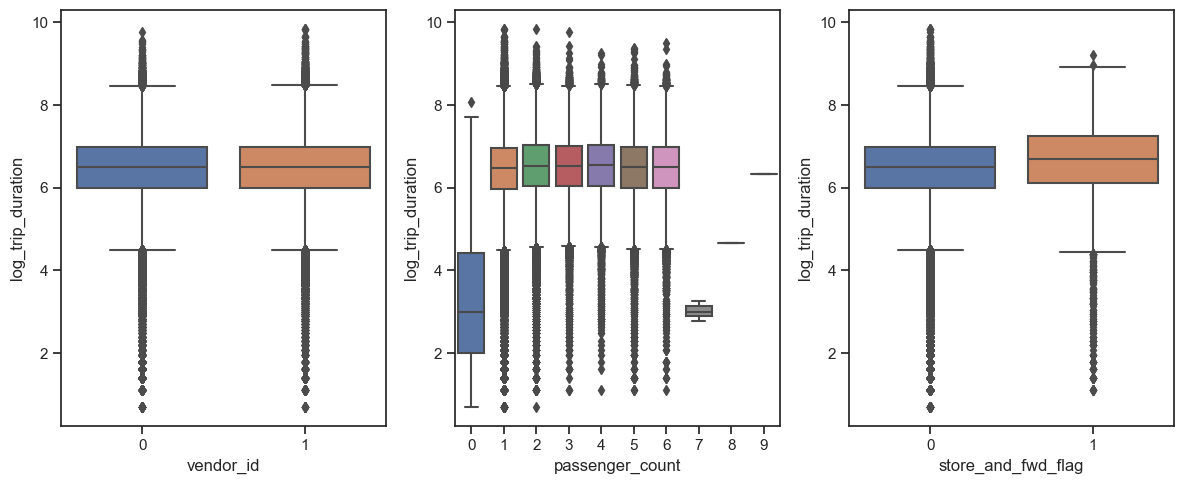

In [136]:
sns.set(style="ticks")

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
sns.boxplot(data=data, x='vendor_id', y=data['log_trip_duration'], ax=axes[0])
sns.boxplot(data=data, x='passenger_count', y=data['log_trip_duration'], ax=axes[1])
sns.boxplot(data=data, x='store_and_fwd_flag', y=data['log_trip_duration'], ax=axes[2])
plt.tight_layout()
plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [137]:
data['vendor_id'] = data['vendor_id'].apply(lambda x: 1 if x == 2 else 0)
data['store_and_fwd_flag'] = data['store_and_fwd_flag'].apply(lambda x: 1 if x == 'Y' else 0)

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [155]:
categorical_features = []
numeric_features = ['period_anomaly', 'traffic_peak', 'free_roads', 'start_in_location_1', 'start_in_location_2', 'end_in_location_1', 'end_in_location_2', 'start_cell', 'end_cell', 'vendor_id', 'store_and_fwd_flag', 'passenger_count']

y = train["log_trip_duration"]
X = train.drop(columns=['trip_duration', 'log_trip_duration', 'id', 'pickup_datetime'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(alpha=26.6))
])

model1 = pipeline.fit(X_train, y_train)

y_train_pred = model1.predict(X_train)
rmse = mean_squared_error(y_train, y_train_pred, squared=False)
print("Train RMSE = %.4f" % rmse)

y_test_pred = model1.predict(X_test)
rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print("Test RMSE = %.4f" % rmse)

score = model1.score(X_test, y_test)
print("R^2 Score: %.4f" % score)

Train RMSE = 0.4973
Test RMSE = 0.4924
R^2 Score: 0.5958


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

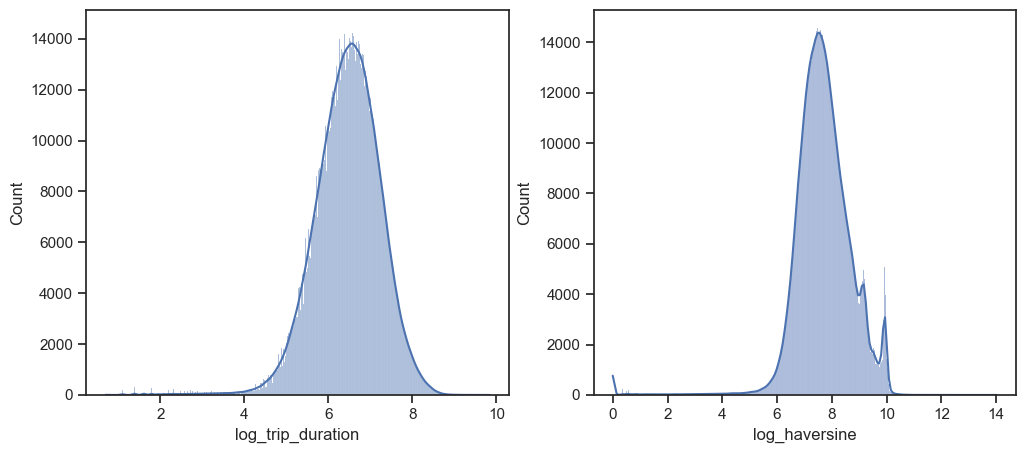

In [144]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data['log_trip_duration'], kde=True, ax = axes[0])
sns.histplot(data['log_haversine'], kde=True, ax = axes[1])
plt.show()

In [ ]:
data = data[(3 <= data['log_trip_duration']) & (data['log_trip_duration']<= 9)]
data = data[(4 <= data['log_haversine']) & (data['log_haversine'] <= 10.2)]

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

In [115]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [116]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [153]:
from sklearn.linear_model import Lasso

categorical_features = []
numeric_features = ['period_anomaly', 'traffic_peak', 'free_roads', 'start_in_location_1', 'start_in_location_2', 'end_in_location_1', 'end_in_location_2', 'start_cell', 'end_cell', 'vendor_id', 'store_and_fwd_flag', 'passenger_count']

y = train["log_trip_duration"]
X = train.drop(columns=['trip_duration', 'log_trip_duration', 'id', 'pickup_datetime'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(alpha=26.6))
])

model1 = pipeline.fit(X_train, y_train)

y_train_pred = model1.predict(X_train)
rmse = mean_squared_error(y_train, y_train_pred, squared=False)
print("Train RMSE = %.4f" % rmse)

y_test_pred = model1.predict(X_test)
rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print("Test RMSE = %.4f" % rmse)

score = model1.score(X_test, y_test)
print("R^2 Score: %.4f" % score)

Train RMSE = 0.6345
Test RMSE = 0.6097
R^2 Score: 0.3804


Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [156]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

alphas = {'alpha': np.logspace(-2, 3, 20)}

ridge_searcher = GridSearchCV(Ridge(), alphas, scoring='r2', cv=5)
ridge_searcher.fit(X_val, y_val)
best_ridge_alpha = ridge_searcher.best_params_['alpha']

lasso_searcher = GridSearchCV(Lasso(), alphas, scoring='r2', cv=5)
lasso_searcher.fit(X_val, y_val)
best_lasso_alpha = lasso_searcher.best_params_['alpha']

ridge_model = Ridge(alpha=best_ridge_alpha)
ridge_model.fit(X_train, y_train)

lasso_model = Lasso(alpha=best_lasso_alpha)
lasso_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_test)
ridge_score = r2_score(y_test, y_pred_ridge)

y_pred_lasso = lasso_model.predict(X_test)
lasso_score = r2_score(y_test, y_pred_lasso)
print(f'Best ridge alpha: {best_ridge_alpha}')
print(f'Best lasso alpha: {best_lasso_alpha}')

print("Ridge R2 score on test set:", ridge_score)
print("Lasso R2 score on test set:", lasso_score)


Ridge R2 score on test set: 0.5964530528840903
Lasso R2 score on test set: 0.5889911050912044


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

id  vendor_id     pickup_datetime  passenger_count  \
0  id2875421          0 2016-03-14 17:24:55                1   
1  id2377394          0 2016-06-12 00:43:35                1   
2  id3858529          0 2016-01-19 11:35:24                1   
3  id3504673          0 2016-04-06 19:32:31                1   
4  id2181028          0 2016-03-26 13:30:55                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         40.765602   
1        -73.980415        40.738564         -73.999481         40.731152   
2        -73.979027        40.763939         -74.005333         40.710087   
3        -74.010040        40.719971         -74.012268         40.706718   
4        -73.973053        40.793209         -73.972923         40.782520   

   store_and_fwd_flag  trip_duration  ...  month  period_anomaly    haversine  \
0                   0            455  ...      3               0  1498.520780   
1                   0            663  ...      6               0  1805.507169   
2                   0           2124  ...      1               0  6385.098495   
3                   0            429  ...      4               0  1485.498423   
4                   0            435  ...      3               0  1188.588459   

   log_haversine  traffic_peak  free_roads  start_in_location_1  \
0       7.312901             1           0                False   
1       7.499151             0           1                False   
2       8.761879             1           0                False   
3       7.304179             1           0                False   
4       7.081363             1           0                False   

   end_in_location_1  start_in_location_2  end_in_location_2  
0              False                False              False  
1              False                False              False  
2              False                False              False  
3              False                False              False  
4              False                False              False  

[5 rows x 24 columns]

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [172]:
from collections import Counter

interactions = Counter(zip(train["start_cell"], train["end_cell"]))
top_interactions = [interaction[0] for interaction in interactions.most_common(100)]
print(top_interactions)

train["interactions"] = train.apply(lambda row: f'{row["start_cell"]}-{row["end_cell"]}' if (row["start_cell"], row["end_cell"]) in top_interactions else '-1', axis=1)

train.sample(200)

[(24, 24), (25, 25), (25, 24), (24, 25), (35, 35), (25, 35), (14, 24), (24, 14), (35, 25), (24, 35), (24, 13), (35, 24), (13, 13), (13, 24), (14, 14), (24, 23), (23, 24), (14, 13), (14, 25), (13, 14), (25, 26), (25, 14), (26, 25), (13, 23), (23, 23), (23, 13), (25, 13), (35, 36), (13, 25), (14, 23), (25, 36), (26, 26), (23, 14), (36, 36), (35, 26), (26, 35), (26, 36), (24, 36), (55, 24), (24, 15), (14, 35), (25, 23), (80, 24), (24, 26), (23, 25), (25, 15), (65, 24), (35, 13), (13, 35), (36, 35), (23, 35), (36, 25), (15, 24), (24, 55), (24, 80), (15, 25), (35, 14), (80, 25), (26, 24), (13, 22), (24, 22), (55, 25), (23, 33), (36, 26), (25, 37), (24, 34), (24, 65), (35, 23), (14, 15), (65, 25), (24, 33), (25, 55), (24, 12), (22, 22), (24, 45), (15, 14), (13, 12), (25, 80), (13, 33), (26, 37), (14, 26), (23, 22), (36, 24), (33, 33), (24, -1), (25, 34), (24, 37), (25, 45), (25, 65), (14, 36), (24, 44), (80, 13), (36, 37), (80, -1), (14, 22), (37, 36), (35, 34), (80, 35), (55, 13), (26, 14)]

id  vendor_id     pickup_datetime  passenger_count  \
261283   id0179111          1 2016-05-31 11:35:49                1   
789767   id3210862          0 2016-02-21 04:00:37                1   
1055614  id3888673          0 2016-06-26 22:13:18                2   
1404599  id1084944          0 2016-04-20 12:24:36                1   
1172970  id1255783          0 2016-05-25 20:27:38                1   
...            ...        ...                 ...              ...   
62772    id2388342          1 2016-06-24 06:54:09                2   
949537   id2546153          1 2016-06-15 16:17:44                2   
970354   id2203177          1 2016-01-29 08:03:18                1   
905906   id3169610          0 2016-04-25 17:53:26                1   
696176   id1373775          1 2016-03-20 12:56:24                6   

         pickup_longitude  pickup_latitude  dropoff_longitude  \
261283         -73.956177        40.778782         -73.961380   
789767         -73.996185        40.759914         -73.990204   
1055614        -74.008377        40.728962         -73.962814   
1404599        -73.992332        40.737442         -73.993881   
1172970        -73.980980        40.760967         -73.970543   
...                   ...              ...                ...   
62772          -73.981697        40.746666         -74.014000   
949537         -73.968719        40.764381         -73.980530   
970354         -73.992149        40.694778         -73.972702   
905906         -73.976852        40.758221         -73.964455   
696176         -73.991379        40.761372         -73.956749   

         dropoff_latitude  store_and_fwd_flag  trip_duration  ...  free_roads  \
261283          40.771709                   0            583  ...           0   
789767          40.757412                   0            169  ...           1   
1055614         40.805065                   0           1260  ...           1   
1404599         40.724571                   0            998  ...           0   
1172970         40.785816                   0            692  ...           0   
...                   ...                 ...            ...  ...         ...   
62772           40.713928                   0           1101  ...           1   
949537          40.751282                   0            870  ...           0   
970354          40.754379                   0           1337  ...           0   
905906          40.758991                   0            545  ...           0   
696176          40.766750                   0           1032  ...           0   

         start_in_location_1  end_in_location_1  start_in_location_2  \
261283                 False              False                False   
789767                 False              False                False   
1055614                False              False                False   
1404599                False              False                False   
1172970                False              False                False   
...                      ...                ...                  ...   
62772                  False              False                False   
949537                 False              False                False   
970354                 False              False                False   
905906                 False              False                False   
696176                 False              False                False   

         end_in_location_2  start_cell  end_cell  interaction  \
261283               False          35        35        35_35   
789767               False          15        24        15_24   
1055614              False          13        26        13_26   
1404599              False          24        23        24_23   
1172970              False          25        25        25_25   
...                    ...         ...       ...          ...   
62772                False          24        13        24_13   
949537               False          

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [177]:
encoded_train = pd.get_dummies(train, columns=["interactions"])
print(encoded_train.keys())

categorical_features = []
numeric_features = ['period_anomaly', 'traffic_peak', 'free_roads', 'start_in_location_1', 'start_in_location_2', 'end_in_location_1', 'end_in_location_2', 'start_cell', 'end_cell', 'vendor_id', 'store_and_fwd_flag', 'passenger_count']

y = encoded_train["log_trip_duration"]
X = encoded_train.drop(columns=['trip_duration', 'log_trip_duration', 'id', 'pickup_datetime'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model1 = pipeline.fit(X_train, y_train)

y_train_pred = model1.predict(X_train)
rmse = mean_squared_error(y_train, y_train_pred, squared=False)
print("Train RMSE = %.4f" % rmse)

y_test_pred = model1.predict(X_test)
rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print("Test RMSE = %.4f" % rmse)

score = model1.score(X_test, y_test)
print("R^2 Score: %.4f" % score)

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       ...
       'interactions_55-13', 'interactions_55-24', 'interactions_55-25',
       'interactions_65-24', 'interactions_65-25', 'interactions_80--1',
       'interactions_80-13', 'interactions_80-24', 'interactions_80-25',
       'interactions_80-35'],
      dtype='object', length=129)
Train RMSE = 0.4774
Test RMSE = 0.4743
R^2 Score: 0.6250


**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [209]:
# 40.757047, -73.982291

# train["pickup_longitude"] = train["pickup_longitude"] - (-73.982291)
# train["pickup_latitude"] = train["pickup_latitude"] - 40.757047
# train["dropoff_longitude"] = train["dropoff_longitude"] - (-73.982291)
# train["dropoff_latitude"] = train["dropoff_latitude"] - 40.757047


angle = np.deg2rad(-30)
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
rotated_pickup_coordinates = np.dot(train[["pickup_longitude", "pickup_latitude"]].values, rotation_matrix)
rotated_dropoff_coordinates = np.dot(train[["dropoff_longitude", "dropoff_latitude"]].values, rotation_matrix)
train["manhattan_distance"] = np.abs(rotated_pickup_coordinates[:, 0] - rotated_dropoff_coordinates[:, 0])\
                              + np.abs(rotated_pickup_coordinates[:, 1] - rotated_dropoff_coordinates[:, 1])

train["log_manhattan_distance"] = np.log1p(train["manhattan_distance"])

correlation_haversine_with_target = train["log_haversine"].corr(train["log_trip_duration"])
correlation_log_manhattan_with_target = train["log_anhattan_distance"].corr(train["log_trip_duration"])

print("Корреляция между евклидовым расстоянием и таргетом:", correlation_haversine_with_target)
print("Корреляция между манхэттенским расстоянием и таргетом:", correlation_log_manhattan_with_target)

Корреляция между евклидовым расстоянием и таргетом: 0.7032247102794893
Корреляция между манхэттенским расстоянием и таргетом: 0.7033250664636208


Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [211]:
encoded_train = encoded_train.drop(columns=['interaction'])
categorical_features = []
numeric_features = ['period_anomaly', 'traffic_peak', 'free_roads', 'start_in_location_1', 'start_in_location_2', 'end_in_location_1', 'end_in_location_2', 'start_cell', 'end_cell', 'vendor_id', 'store_and_fwd_flag', 'passenger_count', 'log_manhattan_distance']

y = encoded_train["log_trip_duration"]
X = encoded_train.drop(columns=['trip_duration', 'log_trip_duration', 'id', 'pickup_datetime'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model1 = pipeline.fit(X_train, y_train)

y_train_pred = model1.predict(X_train)
rmse = mean_squared_error(y_train, y_train_pred, squared=False)
print("Train RMSE = %.4f" % rmse)

y_test_pred = model1.predict(X_test)
rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print("Test RMSE = %.4f" % rmse)

score = model1.score(X_test, y_test)
print("R^2 Score: %.4f" % score)

Train RMSE = 0.4663
Test RMSE = 0.4650
R^2 Score: 0.6395


**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [124]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.